<a href="https://colab.research.google.com/github/BedinEduardo/Colab_Repositories/blob/master/08_Pytorch_ZTM_Paper_Replicating.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# "What is a machine learning research paper?"

# "Why replicate machine learning research papers?"

Machine Learning Engineer*

1. Download a paper
2. Implement it
3. Keep doing this until you have skills

4. Deploy model

* Machine Learning Engineer also involves building infrastructure around yours models/ data preprocessing steps.

# "Where can you find machine learning research papers?"

Finding machine learning papers - and code

# "What we are doing"

Replicating the *vision transformer* paper (ViT paper)

* Getting setup (*importing previously written code)
* Introduce *machine learning paper replicating* with PyTorch
* *Replicating ViT* for FoodVision Mini
* Training a *custom ViT*
* Feature extraction with a *pretrained ViT*

# 08. Milestone Project 2: PyTorch Paper Replicating

The goal of machine learning research paper replicating is: turn a ML research paper into useful code.

In this notebook, we are going to replicating the Vision Transformer (ViT) architecture/paper with PyTorch

See the groundtruth notebook here:

## 0. Get setup

Let's import code we have previously written + required libraries.

In [ ]:
# For this notebook to run with updated APIs, we need torch 1.12+ and torchvision 0.13+
try:
    import torch
    import torchvision
    assert int(torch.__version__.split(".")[1]) >= 12 or int(torch.__version__.split(".")[0]) == 2, "torch version should be 1.12+"
    assert int(torchvision.__version__.split(".")[1]) >= 13, "torchvision version should be 0.13+"
    print(f"torch version: {torch.__version__}")
    print(f"torchvision version: {torchvision.__version__}")
except:
    print(f"[INFO] torch/torchvision versions not as required, installing nightly versions.")
    !pip3 install -U torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu118
    import torch
    import torchvision
    print(f"torch version: {torch.__version__}")
    print(f"torchvision version: {torchvision.__version__}")

torch version: 2.6.0+cu118
torchvision version: 0.21.0+cu118


In [ ]:
# Continue with regular imports
import matplotlib.pyplot as plt
import torch
import torchvision

from torch import nn
from torchvision import transforms

# Try to get torchinfo, install it if it doesn't work
try:
    from torchinfo import summary
except:
    print("[INFO] Couldn't find torchinfo... installing it.")
    !pip install -q torchinfo
    from torchinfo import summary

# Try to import the going_modular directory, download it from GitHub if it doesn't work
try:
    from going_modular.going_modular import data_setup, engine
    from helper_functions import download_data, set_seeds, plot_loss_curves
except:
    # Get the going_modular scripts
    print("[INFO] Couldn't find going_modular or helper_functions scripts... downloading them from GitHub.")
    !git clone https://github.com/mrdbourke/pytorch-deep-learning
    !mv pytorch-deep-learning/going_modular .
    !mv pytorch-deep-learning/helper_functions.py . # get the helper_functions.py script
    !rm -rf pytorch-deep-learning
    from going_modular.going_modular import data_setup, engine
    from helper_functions import download_data, set_seeds, plot_loss_curves

[INFO] Couldn't find torchinfo... installing it.
[INFO] Couldn't find going_modular or helper_functions scripts... downloading them from GitHub.
Cloning into 'pytorch-deep-learning'...
remote: Enumerating objects: 4393, done.
remote: Counting objects: 100% (1532/1532), done.
remote: Compressing objects: 100% (131/131), done.
remote: Total 4393 (delta 1456), reused 1401 (delta 1401), pack-reused 2861 (from 3)
Receiving objects: 100% (4393/4393), 649.93 MiB | 16.38 MiB/s, done.
Resolving deltas: 100% (2659/2659), done.
Updating files: 100% (248/248), done.


In [ ]:
# Setup the device agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"

device

'cuda'

## 1. Get data

The whole goal of what we are trying to do is replicate the ViT architecture for our FoodVsion Mini model.

To start, we need some data.

Namely, the pizza, steak, and sushi we have using so far.

In [ ]:
# Download pizza, steak, sushi images from GitHub
image_path = download_data(source="https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip",
                           destination="pizza_steak_sushi")
image_path

[INFO] Did not find data/pizza_steak_sushi directory, creating one...
[INFO] Downloading pizza_steak_sushi.zip from https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip...
[INFO] Unzipping pizza_steak_sushi.zip data...


PosixPath('data/pizza_steak_sushi')

In [ ]:
# Setup directory paths to train and test images
train_dir = image_path / "train"
test_dir = image_path / "test"

In [ ]:
train_dir, test_dir

(PosixPath('data/pizza_steak_sushi/train'),
 PosixPath('data/pizza_steak_sushi/test'))

## 2. Build Datasets and DataLoaders

In [ ]:
from torchvision import transforms
from going_modular.going_modular import data_setup

# Create image size
IMG_SIZE = 224  # this comes from table 3 of the ViT paper

# Build transforms pipeline
manual_transforms = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor()
])

print(f"Manually created transforms: {manual_transforms}")


Manually created transforms: Compose(
    Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=True)
    ToTensor()
)


In [ ]:
# Build a batch size of 32 (the paper uses 4096 but it is too big four our  smaller hardware... can always scale up later)
BATCH_SIZE = 32

#BUild dataloaders
train_dataloader, test_dataloader, class_names = data_setup.create_dataloaders(
    train_dir=train_dir,
    test_dir=test_dir,
    transform=manual_transforms,
    batch_size=BATCH_SIZE
)

len(train_dataloader), len(test_dataloader), class_names

(8, 3, ['pizza', 'steak', 'sushi'])

### 2.3 Visualize a single image

As always, let's adhere to the motto, *visualize, visualize, visualize*!

In [ ]:
# Get a batvh of images
image_batch, label_batch = next(iter(train_dataloader))

# Select a single one and label from the batch
image, label = image_batch[0], label_batch[0]

# View the single image and batch shapes
image.shape, label

(torch.Size([3, 224, 224]), tensor(1))

(-0.5, 223.5, 223.5, -0.5)

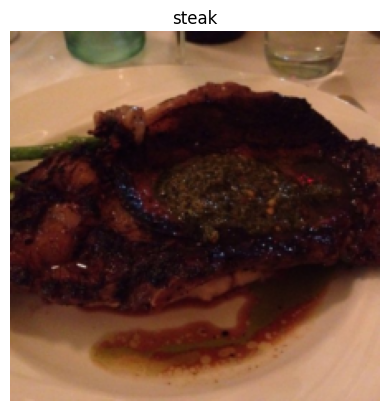

In [ ]:
# Plot the image with matplotlib

import matplotlib.pyplot as plt

plt.imshow(image.permute(1,2,0))  #(color_channels, height, width) -> (height, width, color_channels)
plt.title(class_names[label])
plt.axis(False)

# In a DNN architecture network:
1. Inputs -> Outputs
2. Layers -> Block -> perform specific tasks in the general requiered task
3. Blocks -> General Architecture -> Several blocks with several layers that execute specific tasks, perform a general tasks that is the aim of the mode.

# 3. Replicating ViT: Overview

Looking at a whole machone learning research paper can be in intimidating.

So in order to make it understandable, we can break it down into smaller pieces.

* **Inputs** - What goes into the model? (in our case, image tensors)
* **Outputs** - what comes out of the model / layer / block? (in out case, we want the model to output image classification labels)
* **Layers** - Takes an input, manipulates it with a function (for example could be sef-attention).
* **Blocks** - A collection of layers.
* **Model (or architecture)** - A collection of blocks

### 3.1 ViT overview: pieces of the puzzle

* Figure 1: Visual overview of the architecure
* Four equations: math equations wich define  the function of each layer/block
* Table 1/3: different hyperparameters for the architecture/training.
* Text

### Figure 1

<!-- ![](https://github.com/mrdbourke/pytorch-deep-learning/blob/main/images/08-vit-paper-figure-1-architecture-overview.png?raw=true )-->

<img src="https://github.com/mrdbourke/pytorch-deep-learning/blob/main/images/08-vit-paper-figure-1-architecture-overview.png?raw=true" widht=700, alt="figure 1from vision transformer paper"/>


* Embedding = learnable representation (starts with random numbers and improve over time) -> extra learnable -> peaces of image -> similary of FG PIMM

### Four equation

<!-- ![](https://github.com/mrdbourke/pytorch-deep-learning/blob/main/images/08-vit-paper-four-equations.png?raw=true ) -->

<img src="https://github.com/mrdbourke/pytorch-deep-learning/blob/main/images/08-vit-paper-four-equations.png?raw=true" width=700, alt="four equations from vision transformer paper"/>

#### Section 3.1 describes the various equations:

**Equation 1, 2, 3, and 4**:
<img src="https://cdn.mathpix.com/snip/images/Phoy4U4yuOKE1ZQwRhalS1ffpG0a4J_kax78aRSmJqY.original.fullsize.png" width=800, alt="Vit explanation"/>



### Table 1

<!-- ![](https://github.com/mrdbourke/pytorch-deep-learning/blob/main/images/08-vit-paper-table-1.png?raw=true) -->

<img src="https://github.com/mrdbourke/pytorch-deep-learning/blob/main/images/08-vit-paper-table-1.png?raw=true" width=700, alt="table 1 from vision transformer paper"/>


The first thing that you should look in a model architecture is waht is the input and what is the output, and look how the model perform it.

**Embeddings**: Position embedding gets the image, divide it in peaces - Patches - and add a postion and a image reference -> Linear Projection of Flattened Patches, this sequence serves as input to the Tansformer Encoder.

In pseudocode:
 ```python
 #Equation 1
x_input = [class_token, image_patch_1, image_patch_2, ... image_patch_N] + [class_token_pos, image_patch_1_pos, image_patch_2_pos, ... image_patch_N_pos]

 ```

```python
# Equation 2
x_output_MSA_block = MSA_layer(LN_layer(x_input)) + x_input

# Equation 3
x_output_MLP_block = MLP_layer(LN_layer(x_output_MSA_block)) + x_output_MSA_block

```

* MLP = multilayer perceptron = a neural network with X number of layers -> **a feedforward artificial neural network that generates a set of outputs froma set of inputs.**

* MLP = one hidden layer at training time

* MLP = single linear layer at fine-tuning time

* BERT = **is an open source machine learning framework for natural language processing (NLP)**. In ViT is used to represent images, `class` token, that represent class, class sample that wants to classify belongs too. -> We pretended a learnable embedding to the sequence of embedded patches.

In pseudocode:
```python
# Equation 4
y =  Linear_layer(LN_layer(x_output_MLP_block))
```

* ViT-base, ViT-Large and ViT-Huge are all diferent sizes of the same model architecture.
* Layers - the number of transformers enconder layers
* Hidden size $D$ - the embeddingsize troughout the architecure
* MLP size - the number of hidden number of units/neurons in MLP
* Heads - the number of multi-head self-attention

---

**Transforms BlocK**: Alterating layers of multiheaded self-attention MSA -> `LayerNorm` is applyed before each **MultiHead Attention Block**

**Multihead attention**: MSA block -> equation 2

**MLP blocks**: MLP -> equation 3

**Resiual conections `+`**: Skip connections -> adds the error by subsequent layer in the next one -> get the output of Norm and MLP block and add it in input loss. -> The patterns that the layers are building behind the scenes, a lot of numbers, if these numbers become too small, generate a numerical unstable, add the input to the output prevent to turns it too small, so that our gradient or loss explode. So we can reatin the input in to output.


## 4. Equation 1: Split data into patches and build the class, position, and patch embedding

ViT overview: Workflow -
1. Divide image in patches
2. Convolutional feature maps act as patch embeddings
3. Prepend class token embedding
43. Add position embeddings
5. Class embedding -> the sedond information in the identification
6. Pass patch and position embeddings to Transformer Encoder layer(s)
7. Pass output of Transformer Encoder layer(s) to MLP head
8. The output of MLP returns the class

Layers = input -> function -> output

What is the input shape?

What is the output shape?

* Input shape: $Hx\times{W}x\times{C}$ (height x width x color_channels)
* Output shape: $ \mathbb{R}^{N \times\left(P^{2} \cdot C\right)}$
* H = height
* W = Width
* C = color channels
* P = patch size
* N = number of patches = (height * width)/p^2
* D = constant latent vector size = embedding dimension (see Table 1)

* Input shape: (224, 224, 3) -> Single image -> (height, width, color_channels)
* Output shape: ???

In [ ]:
# Build example values
height = 224
width = 224
color_channels = 3
patch_size = 16

# Calculate the number of patches
number_of_patches = int((height*width) / patch_size**2)   # ² -> **

number_of_patches

196

In [ ]:
# Input shape
embedding_layer_input_shape = (height, width, color_channels)

# Output shape
embedding_layer_output_shape = (number_of_patches, patch_size**2 * color_channels)

print(f"Input shape (single 2D image): {embedding_layer_input_shape}")
print(f"Output shape (single 1d sequence of patches): {embedding_layer_output_shape} -> (Number_of_patches, embedding_dimension)")

Input shape (single 2D image): (224, 224, 3)
Output shape (single 1d sequence of patches): (196, 768) -> (Number_of_patches, embedding_dimension)


### 4.2 Turning a single image into patches

Let's *visualize, visualize, visualize!*


(-0.5, 223.5, 223.5, -0.5)

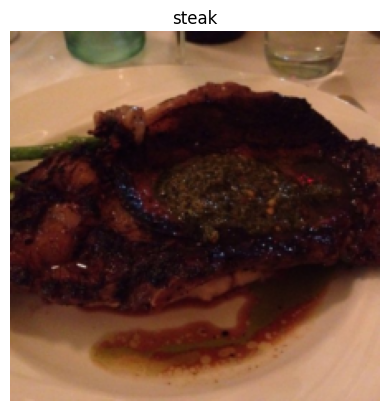

In [ ]:
# View a singel image
plt.imshow(image.permute(1,2,0))
plt.title(class_names[label])
plt.axis(False)

In [ ]:
image.shape

torch.Size([3, 224, 224])

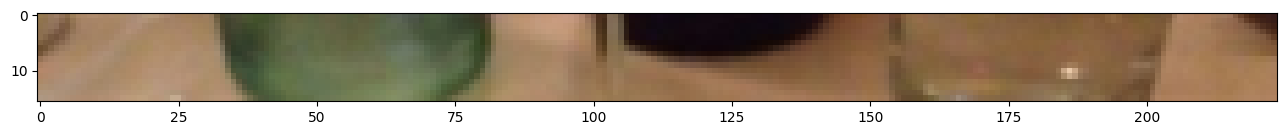

In [ ]:
# Get the top row of the image

image_permuted = image.permute(1,2,0)  # convert the color channel last (H, W, C)

# Index to plot the top row of pixels
patch_size = 16
plt.figure(figsize=(patch_size, patch_size))
plt.imshow(image_permuted[:patch_size,:,:])

#EMBEDDING -> A GOOD LEARNING REPRESENTATION -> THE ARCHITECTURE PROBABILY WILL LEARN SOME THING


Number of patches per row: 14.0 
 Patch size: 16 pixels x 16 pixels


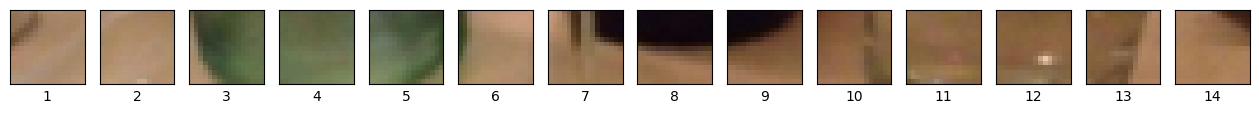

In [ ]:
# Setup code to plot top row as patches
img_size = 224
patch_size = 16
num_patches = img_size / patch_size

assert img_size % patch_size  == 0, "Image size must be divisible by patch size"
print(f"Number of patches per row: {num_patches} \n Patch size: {patch_size} pixels x {patch_size} pixels")
#Build a series of subplots
fig, axs = plt.subplots(nrows=1,
                        ncols=img_size // patch_size, #one column for each patch
                        sharex=True,
                        sharey=True,
                        figsize=(patch_size, patch_size)
                        )

# Iterate through number of patches in the top row
for i, patch in enumerate(range(0, img_size, patch_size)):
  #print(patch)
  axs[i].imshow(image_permuted[:patch_size, patch:patch+patch_size, :]); #: means select all the ranges of the variable -> all the color channles
  axs[i].set_xlabel(i+1)  #set the patch label
  axs[i].set_xticks([])
  axs[i].set_yticks([])

Number of patches per row: 14.0  
 Number of patches per column: 14.0  
 Total patches: 196.0  
 Patch size: 16 pixels x 16 pixels


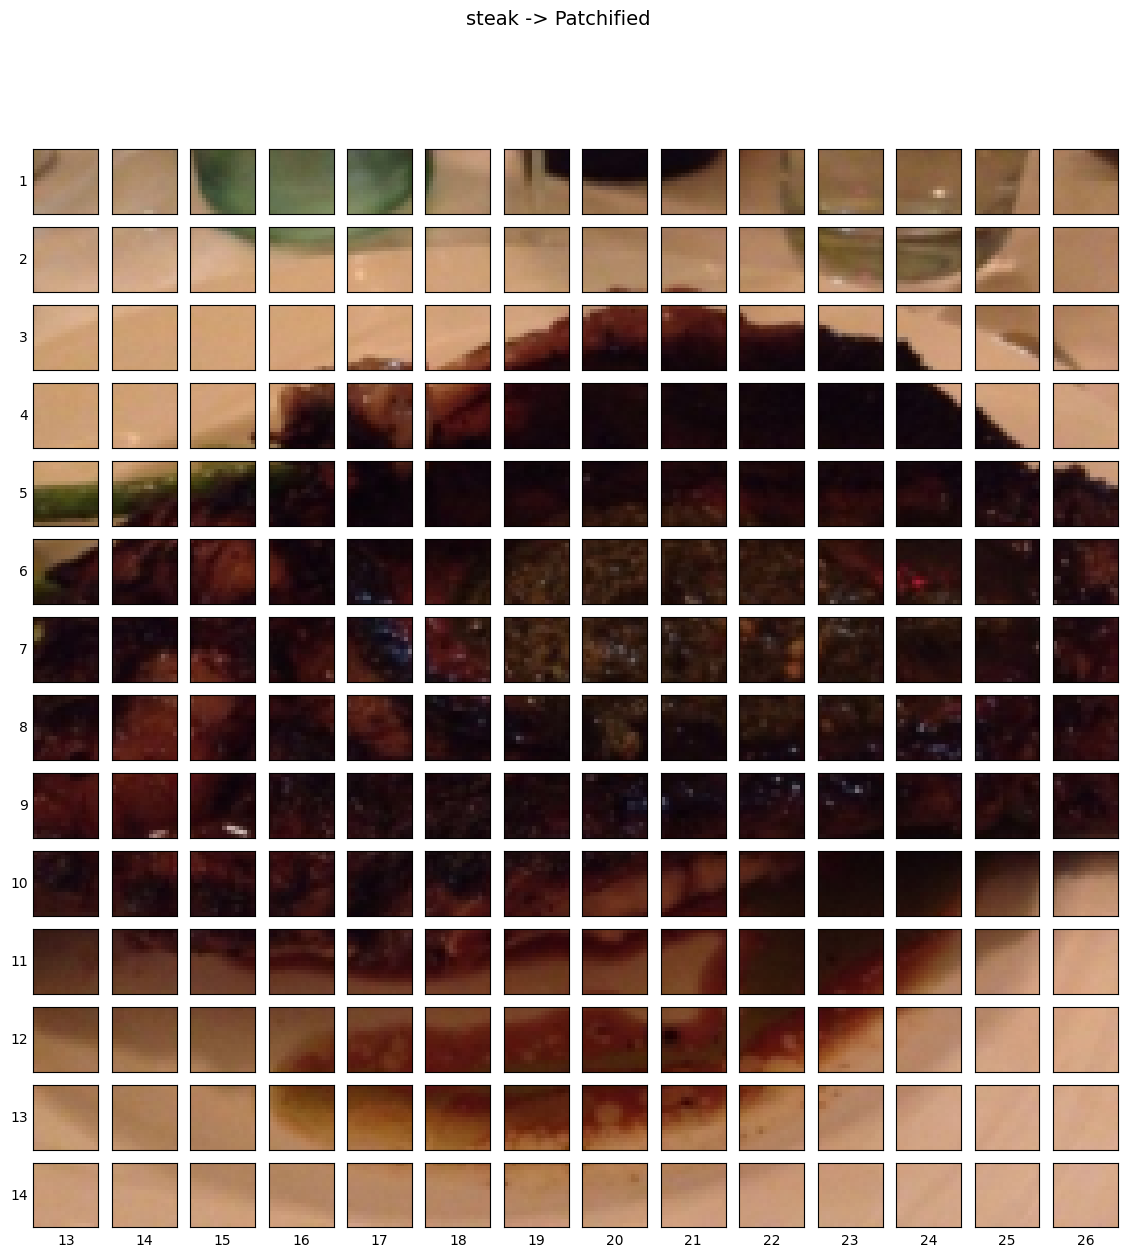

In [ ]:
# Setup code to plot whole image as patches
img_size = 224
patch_size = 16
num_patches = img_size/patch_size

assert img_size % patch_size == 0, "Image size must be divisible by patch size"
print(f"Number of patches per row: {num_patches} \
 \n Number of patches per column: {num_patches} \
 \n Total patches: {num_patches*num_patches} \
 \n Patch size: {patch_size} pixels x {patch_size} pixels")

# Lets now build a series of subplot
fig, axs = plt.subplots(nrows=img_size // patch_size,
                        ncols=img_size // patch_size,
                        figsize=(num_patches, num_patches),
                        sharex=True,
                        sharey=True
                        )

# Loop trough height and width of image
for i, patch_height in enumerate(range(0, img_size, patch_size)): #iterate trough height
  for j, patch_width in enumerate(range(0, img_size, patch_size)):
    # plot the prermuted image on the different axes
    axs[i,j].imshow(image_permuted[patch_height:patch_height+patch_size, #iterate through height
                                   patch_width:patch_width+patch_size,  #iterate thought widht
                                   :])  #get all color channels

    #setup label information for each subplot (patch)
    axs[i, j].set_ylabel(i+1,
                         rotation="horizontal",
                         horizontalalignment="right",
                         verticalalignment="center")
    axs[i,j].set_xlabel(j+i)
    axs[i,j].set_xticks([])
    axs[i,j].set_yticks([])
    axs[i,j].label_outer()

# setup the title for the plot
fig.suptitle(f"{class_names[label]} -> Patchified", fontsize=14)
plt.show()


### 4.3 Building images patches and turning them into patch embedding

Perhaps we could build the image patches and image patch embeddings in a single step using `torch.nn.conv2d()` and setting the kernel size and stride parameters to `patch_size`.



In [ ]:
# Build conv2d layer to turn image patches of learnable features maps - embeddings

from torch import nn

# Set the patch size
patch_size = 16

# Build a conv2d layer with hyperparameters from the ViT paper
conv2d = nn.Conv2d(in_channels=3, # for color images
                   out_channels=768,  #D size from table 1
                   kernel_size=patch_size,
                   stride=patch_size,
                   padding=0)

conv2d

Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))

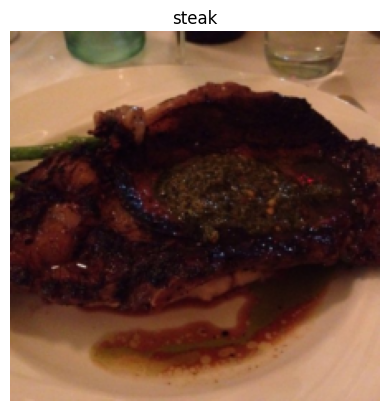

In [ ]:
# View a single image
plt.imshow(image.permute(1,2,0))
plt.title(class_names[label])
plt.axis(False);



In [ ]:
# Pass the image trough the convolutional layer
image_out_of_conv = conv2d(image.unsqueeze(0))   #add batch dimension -> (batch_size, color_channels, height, width)
print(image_out_of_conv.shape)

torch.Size([1, 768, 14, 14])


Now we have to passed a single image to our `conv2d` layer, it's shape is:

```python
torch.Size([1,768,14,14]) # [batch_size, embedding_dim, feature_map_height, feature_map_width]


```

In [ ]:
image_out_of_conv.requires_grad

True

Showing random convolutional feature maps from indexes: [289, 245, 530, 115, 549]


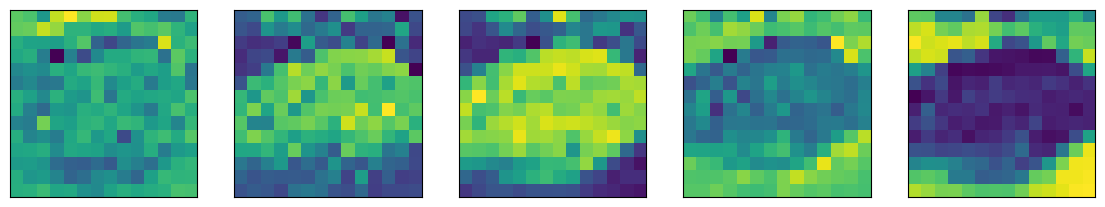

In [ ]:
# Plot random convolutional features maps - embeddings
import random
random_indexes = random.sample(range(0,768),k=5)
print(f"Showing random convolutional feature maps from indexes: {random_indexes}")

# Build plot
fig, axs = plt.subplots(nrows=1, ncols=5, figsize=(14,14))

# Plot random image feature maps
for i, idx in enumerate(random_indexes):
  image_conv_feature_map = image_out_of_conv[:, idx, :, :,]   # Index on the output tensor of the conv2d layer
  axs[i].imshow(image_conv_feature_map.squeeze().detach().numpy())  #remove batch dimension, and remove from grad tracking / switch to numpy for matplot lib
  axs[i].set(xticklabels=[], yticklabels=[], xticks=[],yticks=[])

In [ ]:
# Get a single feature map in tensor form
single_feature_map = image_out_of_conv[:,0,:,:]
single_feature_map, single_feature_map.requires_grad   # Learnable representation of the image

(tensor([[[0.3214, 0.3298, 0.1839, 0.1571, 0.1529, 0.2565, 0.3078, 0.1344,
           0.1215, 0.2263, 0.2692, 0.2212, 0.2162, 0.2971],
          [0.3659, 0.3871, 0.3760, 0.3151, 0.3118, 0.3692, 0.3090, 0.3269,
           0.3230, 0.3580, 0.2674, 0.2074, 0.2420, 0.3147],
          [0.3885, 0.3984, 0.4032, 0.4025, 0.3739, 0.4386, 0.3157, 0.1665,
           0.1076, 0.2005, 0.2528, 0.2160, 0.2909, 0.2508],
          [0.3899, 0.4106, 0.3736, 0.2026, 0.1893, 0.1988, 0.0370, 0.0238,
           0.0271, 0.0105, 0.0078, 0.0010, 0.2252, 0.3995],
          [0.1818, 0.1842, 0.1429, 0.0539, 0.0056, 0.0192, 0.0163, 0.0177,
           0.0486, 0.0410, 0.0450, 0.0406, 0.0290, 0.0702],
          [0.1855, 0.0628, 0.1478, 0.0443, 0.0624, 0.0326, 0.0407, 0.0448,
           0.0574, 0.0637, 0.1135, 0.0905, 0.0398, 0.0835],
          [0.0813, 0.0368, 0.0988, 0.0399, 0.0704, 0.1126, 0.0519, 0.0762,
           0.0586, 0.0891, 0.0928, 0.0712, 0.0804, 0.0421],
          [0.0992, 0.1301, 0.1537, 0.0528, 0.1196, 0.03

### 4.4 Flattening the patch embedding with `torch.nn.Flatten()`

Right now we have a series of convolutional features maps (patch embeddings) that we want to flatten into a sequence of patch embeddings to satisfy the input criteria of ViT Transformer Encoder.

In [ ]:
print(f"{image_out_of_conv.shape} -> (batch_size, emedding_dim, feature_map_height, feature_map_width)")


torch.Size([1, 768, 14, 14]) -> (batch_size, emedding_dim, feature_map_height, feature_map_width)


Want: (batch_size, number_of_patches, embedding_dim)

In [ ]:
from torch import nn
flatten_layer = nn.Flatten(start_dim=2,
                           end_dim=3)

flatten_layer(image_out_of_conv).shape

torch.Size([1, 768, 196])

Original image shape: torch.Size([3, 224, 224])
Image feature map (patches) shape: torch.Size([1, 768, 14, 14])
Flattened image feature map shape: torch.Size([1, 768, 196])


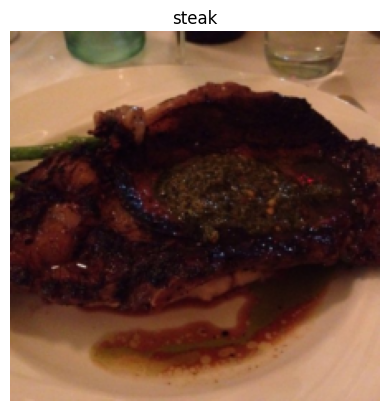

In [ ]:
# Put everything together
plt.imshow(image.permute(1,2,0))
plt.title(class_names[label])
plt.axis(False)

print(f"Original image shape: {image.shape}")

# Turn image into feature maps
image_out_of_conv = conv2d(image.unsqueeze(0))   # add batch dimension
print(f"Image feature map (patches) shape: {image_out_of_conv.shape}")

# Flatten the feature maps
image_out_of_conv_flattened = flatten_layer(image_out_of_conv)
print(f"Flattened image feature map shape: {image_out_of_conv_flattened.shape}")


In [ ]:
# Rearange output of flattened layer
image_out_of_conv_flattened_permuted = image_out_of_conv_flattened.permute(0,2,1)
print(f"{image_out_of_conv_flattened.permute(0,2,1).shape} -> (batch_size, number_of_patches, embedding_dimension)")

torch.Size([1, 196, 768]) -> (batch_size, number_of_patches, embedding_dimension)


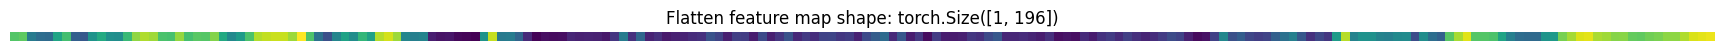

In [ ]:
# Get a single flattened feature map
single_flattened_feature_map = image_out_of_conv_flattened_permuted[:, :, 0]
single_flattened_feature_map

# Plot the flattened feature map visually
plt.figure(figsize=(22,22))
plt.imshow(single_flattened_feature_map.detach().numpy())
plt.title(f"Flatten feature map shape: {single_flattened_feature_map.shape}")
plt.axis(False);

### 4.5 Turning the ViT patch embedding layer into PyTorch module

We want this module to do few things:
1. Build a class called `PatchEmbedding`, with subclasses `nn.module` - so it can be used a PyTorch layer
2. Initialize with appropriate hyperparameters, sucha as channels, embedding dimensions, patch size.
3. Build a layer to turn an image into embedding patches using `nn.Conv2d()`
4. Build a layer to flatten the features maps of the output of the layer in 3 .
5. Define a `foward()` method that defines the forward computation - e.g: pass trough layer from 3 and 4
6. Make sure the output shape of the layer reflects the required output shape of the patche embedding.

**. *The building of a deep neural network starts with the first layer* .**

In [ ]:
# 1. Build a class called PatchEmbedding
class PatchEmbedding(nn.Module):
  # Initialize the layer with appropriate Hyperparameters
  def __init__(self,
               in_channels:int=3,
               patch_size:int=16,
               embedding_dim:int=768): # From table 1 for ViT-Base paper
    super().__init__()
    self.patch_size = patch_size

    # 3. Build a layer to turn an image into embedded patches
    self.patcher = nn.Conv2d(in_channels=in_channels,
                             out_channels=embedding_dim,
                             kernel_size=patch_size,
                             stride=patch_size,
                             padding=0)

    # 4. Build a layer to flatten feature map outputs of Conv2d
    self.flatten = nn.Flatten(start_dim=2,
                              end_dim=3)

  # 5. Build a forward method to define the forward computation steps
  def forward(self, x):
    # Build assertion to check that inputs are the correct shape
    image_resolution = x.shape[-1]  #get the last dimension
    assert image_resolution % patch_size ==0, f"Input image size must be divisible by patch size: {image_resolution}, patch size: {self.patch_size}"

    # Perform the forward pass
    x_patched = self.patcher(x)
    x_flattened = self.flatten(x_patched)

    # 6. Make sure the returned sequence embedding dimensions are in the right order (batch_size, number_of_patches, embedding_dimension)
    return x_flattened.permute(0,2,1)


In [ ]:
set_seeds()

# Build an isntance of patch embedding layer
patchify = PatchEmbedding(in_channels=3,
                         patch_size=16,
                         embedding_dim=768)

# Pass a single image trough patch single layer
print(f"Input image size: {image.unsqueeze(0).shape}")
patch_embedded_image = patchify(image.unsqueeze(0))  #Add an extra dimension
print(f"Output patch embedding sequence shape: {patch_embedded_image.shape}")

Input image size: torch.Size([1, 3, 224, 224])
Output patch embedding sequence shape: torch.Size([1, 196, 768])


In [ ]:
rand_image_tensor = torch.randn(1,3,224,224)
rand_image_tensor_bad = torch.rand(1,3,250,250)

patchify(rand_image_tensor)

tensor([[[-0.3601,  0.2602, -0.7408,  ..., -1.2910, -0.2012, -0.0354],
         [-0.3405,  0.6132,  0.6626,  ..., -0.6314, -1.8604,  0.3311],
         [-0.0176, -0.2323, -0.1009,  ...,  0.1873,  0.6899, -0.5419],
         ...,
         [ 0.5333, -0.7641, -0.1217,  ...,  0.2381,  0.5565,  0.0466],
         [-0.6577, -0.0324, -0.6278,  ..., -0.1591,  0.7905,  1.4529],
         [-1.1716, -0.1617, -0.1427,  ...,  0.5600,  0.4640,  0.7539]]],
       grad_fn=<PermuteBackward0>)

### 4.6 Building the class token embedding

Want to: prepend a learnable class token to the start of the patch embedding.

In [ ]:
patch_embedded_image.shape

torch.Size([1, 196, 768])

In [ ]:
# Get the batch size and embedding dimension
batch_size = patch_embedded_image.shape[0]
embedding_dimension = patch_embedded_image.shape[-1]
batch_size, embedding_dimension

(1, 768)

In [ ]:
# Build class token embedding as a learnable parameter that shares the same size as the embedding dimension (D)
class_token = nn.Parameter(torch.ones(batch_size, 1, embedding_dimension),
                           requires_grad=True)

class_token.shape

torch.Size([1, 1, 768])

In [ ]:
patch_embedded_image.shape

torch.Size([1, 196, 768])

In [ ]:
# Add the class token embedding to the front of the patch embedding
patch_embedded_with_class_embedding = torch.cat((class_token, patch_embedded_image),
                                                dim=1)  #the number_of_patches_dimension
print(patch_embedded_with_class_embedding)
print(f"Sequences of patch embeddings with class token prepend shape: {patch_embedded_with_class_embedding} -> (batch_size, class_token + number_of_patches, embedding_dim)")

tensor([[[ 1.0000,  1.0000,  1.0000,  ...,  1.0000,  1.0000,  1.0000],
         [-0.5910,  0.1253, -0.1901,  ...,  0.4012, -0.2310,  0.2190],
         [-0.5993,  0.0906, -0.1907,  ...,  0.4369, -0.2738,  0.2304],
         ...,
         [-0.7460,  0.1450, -0.1664,  ...,  0.5069, -0.3613,  0.2899],
         [-0.7817,  0.1511, -0.1626,  ...,  0.5121, -0.3625,  0.2824],
         [-0.7687,  0.1593, -0.1664,  ...,  0.5207, -0.3658,  0.2842]]],
       grad_fn=<CatBackward0>)
Sequences of patch embeddings with class token prepend shape: tensor([[[ 1.0000,  1.0000,  1.0000,  ...,  1.0000,  1.0000,  1.0000],
         [-0.5910,  0.1253, -0.1901,  ...,  0.4012, -0.2310,  0.2190],
         [-0.5993,  0.0906, -0.1907,  ...,  0.4369, -0.2738,  0.2304],
         ...,
         [-0.7460,  0.1450, -0.1664,  ...,  0.5069, -0.3613,  0.2899],
         [-0.7817,  0.1511, -0.1626,  ...,  0.5121, -0.3625,  0.2824],
         [-0.7687,  0.1593, -0.1664,  ...,  0.5207, -0.3658,  0.2842]]],
       grad_fn=<CatBack

In [ ]:
rand_image_tensor = torch.randn(1,3, 224, 224)
rand_image_tensor_bad = torch.randn(1,3,250,250)

patchify(rand_image_tensor)

tensor([[[-0.4717, -0.1079,  0.3510,  ...,  0.5733, -0.4891, -0.0769],
         [-0.4885,  0.2685,  0.0526,  ..., -0.0460, -0.4193,  0.5629],
         [-0.8523, -0.3679, -0.9438,  ..., -0.0791,  0.0711, -0.6256],
         ...,
         [-0.1669,  0.2006,  0.6736,  ...,  0.4029, -0.2412,  0.2380],
         [-0.2699, -0.1790,  0.6158,  ..., -0.0697, -0.7212,  0.0853],
         [ 0.0545,  0.1980,  0.3134,  ..., -0.2953, -0.1441, -1.7263]]],
       grad_fn=<PermuteBackward0>)

### 4.7 Building the postion embedding

Want to: build a series of 1D learnable position embeddings add them to the sequence of patch embeddings.

In [ ]:
# View the sequence of patch embeddings with the prepend class embedding
patch_embedded_with_class_embedding, patch_embedded_with_class_embedding.shape

(tensor([[[ 1.0000,  1.0000,  1.0000,  ...,  1.0000,  1.0000,  1.0000],
          [-0.5910,  0.1253, -0.1901,  ...,  0.4012, -0.2310,  0.2190],
          [-0.5993,  0.0906, -0.1907,  ...,  0.4369, -0.2738,  0.2304],
          ...,
          [-0.7460,  0.1450, -0.1664,  ...,  0.5069, -0.3613,  0.2899],
          [-0.7817,  0.1511, -0.1626,  ...,  0.5121, -0.3625,  0.2824],
          [-0.7687,  0.1593, -0.1664,  ...,  0.5207, -0.3658,  0.2842]]],
        grad_fn=<CatBackward0>),
 torch.Size([1, 197, 768]))

In [ ]:
# Calculate N (number_of_batches)
number_of_patches = int((height * width)/patch_size**2)
#number_of_patches

# Getting the embedding dimension
embedding_dimension = patch_embedded_with_class_embedding.shape[-1]
#embedding_dimension

# Buiuld learnable 1D position embediding
position_embedding = nn.Parameter(torch.ones(1,
                                             number_of_patches+1,
                                             embedding_dimension))
position_embedding, position_embedding.shape


(Parameter containing:
 tensor([[[1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.],
          ...,
          [1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.]]], requires_grad=True),
 torch.Size([1, 197, 768]))

In [ ]:
# Add the position embedding to the patch and class token embedding
patch_and_position_embedding = patch_embedded_with_class_embedding + position_embedding

print(patch_and_position_embedding)
print(f"Patch and position embedding shape: {patch_and_position_embedding.shape}")

tensor([[[2.0000, 2.0000, 2.0000,  ..., 2.0000, 2.0000, 2.0000],
         [0.4090, 1.1253, 0.8099,  ..., 1.4012, 0.7690, 1.2190],
         [0.4007, 1.0906, 0.8093,  ..., 1.4369, 0.7262, 1.2304],
         ...,
         [0.2540, 1.1450, 0.8336,  ..., 1.5069, 0.6387, 1.2899],
         [0.2183, 1.1511, 0.8374,  ..., 1.5121, 0.6375, 1.2824],
         [0.2313, 1.1593, 0.8336,  ..., 1.5207, 0.6342, 1.2842]]],
       grad_fn=<AddBackward0>)
Patch and position embedding shape: torch.Size([1, 197, 768])


#### Equation 1.

1. **Patch embeddings** with **learnable class token** -> the "first line" of the tensor
2. Build **position embeddings** and add to patch embeddings with learnable class token
3. **Patch embeddings** with **learnable class token** and **postion embeddings**

### 4.8 Putting it all together: from image to embedding

we have written code to turn an image into a flattened sequence of patch embeddings.

Now let's see all in one cell.

In [ ]:
from os import path
#Set seeds
set_seeds()

# 1. Set the patch size
patch_size = 16

# 2. Print out the shapes of the original image tensor and get the image dimensions
print(f"Image tensorshape: {image.shape}")
height, width = image.shape[1], image.shape[2]

# 3. Get image tensor and add a batch dimension
x = image.unsqueeze(0)
print(f"Input image shape: {x.shape}")

# 4. Build patch embedding layer
patch_embedding_layer = PatchEmbedding(in_channels=3,
                                       patch_size=patch_size,
                                       embedding_dim=768)

# 5. Pass input image through PatchEmbedding
patch_embedding = patch_embedding_layer(x)
print(f"Patch embedidng shape: {patch_embedding.shape}")

# 6. Build class token embedding
batch_size = patch_embedding .shape[0]
embedding_dimension = patch_embedding.shape[-1]
class_token = nn.Parameter(torch.ones(batch_size, 1, embedding_dimension),
                           requires_grad=True)  #make sure that it is learnable
print(f"Class token embedding shape: {class_token.shape}")

# 7. Prepend the class token embedding to patch embedding
patch_embedding_class_token =torch.cat((class_token, patch_embedding), dim=1)
print(f"Patch embedding with class token shape: {patch_embedding_class_token.shape}")

# 8. Build position embedding
number_of_patches = int((height*width) / patch_size)
postion_embedding = nn.Parameter(torch.ones(1, number_of_patches+1,embedding_dimension),
                                 requires_grad=True)

# 9. Add the position embedding to patch embedding with class token
patch_and_position_embedding = patch_embedding_class_token + position_embedding
print(f"Patch and postion embedding shape: {patch_and_position_embedding.shape}")

Image tensorshape: torch.Size([3, 224, 224])
Input image shape: torch.Size([1, 3, 224, 224])
Patch embedidng shape: torch.Size([1, 196, 768])
Class token embedding shape: torch.Size([1, 1, 768])
Patch embedding with class token shape: torch.Size([1, 197, 768])
Patch and postion embedding shape: torch.Size([1, 197, 768])


## 5. Equation 2: The MSA Block

* MSA: Multi-head self attention

Consits of alternating layers of multihead self-attention and MLP blocks. Layernorm is applied before every block, and residual connections after every block

## Equation 2: Multihead Self-Attention (MSA block)

* Multihead self-attention: which part of a sequence should pay the most attention to itself?
  * In your case, we have a series of embedded image patches, which patch significantly relate to another patch.
  * We want our neural network(ViT) to learn this relationship/representation.
  * To replicate MSA in PyTorch we can use: - q,k,v -> query, key, values of ech tensor going out from Norm to MSA
  * Layernorm: Unlike batch normalization, Layer Normalization directly estimates the normalization statistics from the summed inputs to the neurons within a hidden layer so the normalization does not introduce any new dependencies between training cases.
  * Normalization = make everything have the same mean and the same standard-deviation.
  * In PyTorch = https://pytorch.org/docs/stable/generated/torch.nn.LayerNorm.html, normalizes values over $D$ dimension, in our case, the $D$ dimension is the embedding dimension.
  * When we normalize along the embedding dimension, it's like making all of the stairs in the staircase the same size.

In [ ]:
class MultiHeadSelfAttentionBlock(nn.Module):
  """
    Build a mult-head self-attention block ("MSA block" for short).
  """
  def __init__(self,
               embedding_dim:int=768, #Hidden size D (embedding dimension) from Table 1 for ViT base
               num_heads:int=12, #Heads from Table 1 for ViT-Base
               attn_dropout:int=0):
    super().__init__()
    # Build the norm layer (LN)
    self.layer_norm = nn.LayerNorm(normalized_shape=embedding_dim)

    # Build the multihead attention layer(MSA) layer
    self.multihead_attn = nn.MultiheadAttention(embed_dim=embedding_dim,
                                                num_heads=num_heads,
                                                dropout=attn_dropout,
                                                batch_first=True) # is the batch first? (batch, seq, feature) -> (batch, number_of_patches, embedding_dimension)

  def forward(self, x):
    x = self.layer_norm(x)
    attn_output, _= self.multihead_attn(query=x,
                                       key=x,
                                        value=x,
                                       need_weights=False)

    return attn_output

In [ ]:
# Build and instance MSA block
multi_head_self_attention_block = MultiHeadSelfAttentionBlock(embedding_dim=768,
                                                              num_heads=12,
                                                              attn_dropout=0)
# Pass the patch and the position image embedding sequence through MSA block
patched_image_trough_msa_block = multi_head_self_attention_block(patch_and_position_embedding)
print(f"Input shape ofg MSA block: {patch_and_position_embedding.shape}")
print(f"Output shape of MSA block: {patched_image_trough_msa_block.shape}")

Input shape ofg MSA block: torch.Size([1, 197, 768])
Output shape of MSA block: torch.Size([1, 197, 768])


In [ ]:
patch_and_position_embedding

tensor([[[2.0000, 2.0000, 2.0000,  ..., 2.0000, 2.0000, 2.0000],
         [0.4090, 1.1253, 0.8099,  ..., 1.4012, 0.7690, 1.2190],
         [0.4007, 1.0906, 0.8093,  ..., 1.4369, 0.7262, 1.2304],
         ...,
         [0.2540, 1.1450, 0.8336,  ..., 1.5069, 0.6387, 1.2899],
         [0.2183, 1.1511, 0.8374,  ..., 1.5121, 0.6375, 1.2824],
         [0.2313, 1.1593, 0.8336,  ..., 1.5207, 0.6342, 1.2842]]],
       grad_fn=<AddBackward0>)

In [ ]:
multi_head_self_attention_block

MultiHeadSelfAttentionBlock(
  (layer_norm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  (multihead_attn): MultiheadAttention(
    (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=True)
  )
)

In [ ]:
patched_image_trough_msa_block

tensor([[[-0.1928, -0.2124,  0.0919,  ..., -0.4090,  0.9099, -0.4943],
         [-0.1915, -0.2069,  0.1002,  ..., -0.4060,  0.9380, -0.5107],
         [-0.1916, -0.2066,  0.1007,  ..., -0.4083,  0.9381, -0.5101],
         ...,
         [-0.1913, -0.2078,  0.1003,  ..., -0.4080,  0.9387, -0.5105],
         [-0.1914, -0.2077,  0.1003,  ..., -0.4079,  0.9388, -0.5105],
         [-0.1912, -0.2079,  0.0999,  ..., -0.4083,  0.9388, -0.5104]]],
       grad_fn=<TransposeBackward0>)

## 6. Equation 3: Multilayer Perceptron (MLP block)

* Residual connections are equivalent to add input to the blocks outputs

* **MLP** = The MLP contains two layers with a GELU non-linearity (section 3.1).
  * MLP = a quite broad term for block of a series of layers(s), layers can be multiple or even only one hidden layer.
  * Layers can mean: fully-connected, dense, linear, feed-foward, all are often similar names for the same thing. In the PyTorch, they are often called `torch.nn.Linear()` and just a reference, in TensorFlow they my be called `tf.keras.Dense()`
  * GELU in PyTorch: https://pytorch.org/docs/stable/generated/torch.nn.GELU.html
  * MLP number of hidden untis = MLP Size in Table 1.
* **Dropout**: When used is applied after devery dense layer except for the qvk-projections after adding positional - to path embeddings. Hybrid models are trained with the exact setup as their ViT counterparts.
  * Value for Dropout available in Table 3.

  In pseudocode:
  ```python
# MLP
x = linear -> non-linear -> dropout -> linear -> non-linear

  ```

In [ ]:
class MLPBlock(nn.Module):
  def __init__(self,
               embedding_dim:int= 768,
               mlp_size:int=3072,
               dropout:int=0.1
               ):
    super().__init__()

    # Build the norm layer(LN)
    self.layer_norm = nn.LayerNorm(normalized_shape=embedding_dim)

    # Build the MLP
    self.mlp = nn.Sequential(
        nn.Linear(in_features=embedding_dim,
                  out_features=mlp_size),
        nn.GELU(),
        nn.Dropout(p=dropout),
        nn.Linear(in_features=mlp_size,
                  out_features=embedding_dim),
        nn.Dropout(p=dropout)
    )

  def forward(self,x):
    x = self.layer_norm(x)
    x = self.mlp(x)
    return x
    #return self.mpl(self.layer_norm(x))

In [ ]:
# Build an instance of MLPBlocl
mpl_block = MLPBlock(embedding_dim=768,
                     mlp_size=3072,
                     dropout=0.1)

# Pass output the MSABlock trough MLPBlock
patched_image_trough_mlp_block = mpl_block(patched_image_trough_msa_block)
print(f"Input shape of MLP block: {patched_image_trough_mlp_block.shape}")
print(f"Output shape of MSA block: {patched_image_trough_msa_block.shape}")

Input shape of MLP block: torch.Size([1, 197, 768])
Output shape of MSA block: torch.Size([1, 197, 768])


In [ ]:
patched_image_trough_mlp_block

tensor([[[-0.0365, -0.0034,  0.1741,  ..., -0.0000, -0.1480,  0.2380],
         [-0.0872, -0.1346,  0.2796,  ..., -0.1891, -0.1387,  0.2197],
         [-0.0074, -0.0435,  0.3053,  ..., -0.0000, -0.1970,  0.2152],
         ...,
         [-0.1661, -0.0234,  0.2743,  ...,  0.0118, -0.2362,  0.3175],
         [-0.1163,  0.0421,  0.0000,  ..., -0.0291, -0.1838,  0.1144],
         [-0.0761, -0.0209,  0.2566,  ..., -0.2019, -0.1422,  0.2288]]],
       grad_fn=<MulBackward0>)

In [ ]:
patched_image_trough_msa_block

tensor([[[-0.1928, -0.2124,  0.0919,  ..., -0.4090,  0.9099, -0.4943],
         [-0.1915, -0.2069,  0.1002,  ..., -0.4060,  0.9380, -0.5107],
         [-0.1916, -0.2066,  0.1007,  ..., -0.4083,  0.9381, -0.5101],
         ...,
         [-0.1913, -0.2078,  0.1003,  ..., -0.4080,  0.9387, -0.5105],
         [-0.1914, -0.2077,  0.1003,  ..., -0.4079,  0.9388, -0.5105],
         [-0.1912, -0.2079,  0.0999,  ..., -0.4083,  0.9388, -0.5104]]],
       grad_fn=<TransposeBackward0>)

## 7. BUilding the Transformer Encoder

The transformer enconder is a combination of alternating blocks of MSA (equation 2) and MLP (equation 3).

And there are residula connections between each block.

* **Encoder**: turn a sequence into learnable representation
* **Decoder**: go from learn representation back to some sort of sequence
* **Residual connections**: add a layer(s) input to its subsequent output, this enables the building of deeper networks(prevent weights from getting too small)

In pseudo code:
```python
# Transformer Enconder
x_input -> MSA_block -> [MSA_block_output + x_input] -> MLP_block -> [MLP_block_output + MSA_block_output + x_input] -> ...
```



### 7.1 Build a custom Transformer Encoder Block

In [ ]:
class TransformerEncoderBlock(nn.Module):
  def __init__(self,
               embedding_dim:int=768, #Hidden size D from table 1 - ViT-Base
               num_heads:int=12, # Table 1
               mlp_size:int=3072, # Table 1
               mlp_dropout:int=0.1,  #from table 3
               attn_dropout:int=0):
    super().__init__()

    # Build the MSA block (eq 2)
    self.msa_block = MultiHeadSelfAttentionBlock(embedding_dim=embedding_dim,
                                                 num_heads=num_heads,
                                                 attn_dropout=attn_dropout)
    # Build MLP block (eq 3)
    self.mlp_block = MLPBlock(embedding_dim=embedding_dim,
                              mlp_size=mlp_size,
                              dropout=mlp_dropout)

  def forward(self, x):
    x = self.msa_block(x) + x   # + x the residual connections - skip connection - for eq2
    x = self.mlp_block(x) + x  #residual / skip connection for eq3

    return x


In [ ]:
#Build an instance of TransformerEncoderBlock()
transfromer_encoder_block = TransformerEncoderBlock()

# Get a summary using torchinfo.summary
summary(model=transfromer_encoder_block,
        input_size=(1,197,768),  # (batch_size, number_of_patches, embedding_dimension)
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings = ["var_names"])


Layer (type (var_name))                            Input Shape          Output Shape         Param #              Trainable
TransformerEncoderBlock (TransformerEncoderBlock)  [1, 197, 768]        [1, 197, 768]        --                   True
├─MultiHeadSelfAttentionBlock (msa_block)          [1, 197, 768]        [1, 197, 768]        --                   True
│    └─LayerNorm (layer_norm)                      [1, 197, 768]        [1, 197, 768]        1,536                True
│    └─MultiheadAttention (multihead_attn)         --                   [1, 197, 768]        2,362,368            True
├─MLPBlock (mlp_block)                             [1, 197, 768]        [1, 197, 768]        --                   True
│    └─LayerNorm (layer_norm)                      [1, 197, 768]        [1, 197, 768]        1,536                True
│    └─Sequential (mlp)                            [1, 197, 768]        [1, 197, 768]        --                   True
│    │    └─Linear (0)                     

### 7.2 Build a Transformer Encoder layer with in-built PyTorch layers

So far we have builded a transformer encoder by hand.

But because fo how good the Transformer architecture is, PyTorch has implemented ready to use Transformer encoder layers

https://pytorch.org/docs/stable/nn.html#transformer-layers


We can build a Transformer Encoder with pure PyTorch layers.

In [ ]:
# Build the same as above with torch.nn.TransformerEncoderLayer()
torch_transformer_encoder_layer = nn.TransformerEncoderLayer(d_model=768,  #embedding size from table 1
                                                             nhead=12,  #heads
                                                             dim_feedforward=3072, # MLP size from tabl e 1
                                                             dropout=0.1,
                                                             activation='gelu',
                                                             batch_first=True,
                                                             norm_first=True)

torch_transformer_encoder_layer

TransformerEncoderLayer(
  (self_attn): MultiheadAttention(
    (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=True)
  )
  (linear1): Linear(in_features=768, out_features=3072, bias=True)
  (dropout): Dropout(p=0.1, inplace=False)
  (linear2): Linear(in_features=3072, out_features=768, bias=True)
  (norm1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  (norm2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  (dropout1): Dropout(p=0.1, inplace=False)
  (dropout2): Dropout(p=0.1, inplace=False)
)

In [ ]:
summary(model=torch_transformer_encoder_layer,
        input_size=(1,197,768),  # (batch_size, number_of_patches, embedding_dimension)
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings = ["var_names"])

Layer (type (var_name))                            Input Shape          Output Shape         Param #              Trainable
TransformerEncoderLayer (TransformerEncoderLayer)  [1, 197, 768]        [1, 197, 768]        --                   True
├─LayerNorm (norm1)                                [1, 197, 768]        [1, 197, 768]        1,536                True
├─MultiheadAttention (self_attn)                   [1, 197, 768]        [1, 197, 768]        2,362,368            True
├─Dropout (dropout1)                               [1, 197, 768]        [1, 197, 768]        --                   --
├─LayerNorm (norm2)                                [1, 197, 768]        [1, 197, 768]        1,536                True
├─Linear (linear1)                                 [1, 197, 768]        [1, 197, 3072]       2,362,368            True
├─Dropout (dropout)                                [1, 197, 3072]       [1, 197, 3072]       --                   --
├─Linear (linear2)                             

Why spend all this time rebuilding the transformer encoder when we could have just made it with a single PyTorchb layer?

Practice, practice, practice

Now we konw how the things are implemented behind the scenes, we can twerk them if necessary.

What are the benefits of using a prebuilt PyTorch Layer?

* Less prone to errors - goes trough a bunch of testing
* Potential benefits of spped ups - performance boosts

## 8. Putting it all together to build ViT

```python
# Build a ViT class
class ViT(nn.Module):
  def __init__(self,
               img_size:int=224,  #Table from the ViT paper
               in_channels:int=3,
               patch_size:int=16,
               num_transformer_layers:int=12,  #Table 1 for layers for ViT-base
               embedding_dim:int=768,  #hidden size D from table 1 ViT-base
               mlp_size:int=3072,  #Table 1
               num_heads:int=12,  # Table 1
               attn_dropout:int=0,
               mlp_dropout:int=0.1,
               embedding_dropout:int=0.1, #Dropout for patch and positions embeddings
               num_classes:int=1000):   #number of classes in our classification  problem - by default 1000
      super().__init__()

      # Make an assertion that the image size is compatible withe the patch size
      assert img_size % patch_size == 0, f"Image size must be divisible by patch size, image: {img_size}, patch size: {patch_size}"

      # Calculate the number of the patches (height * width/patch^2)
      self.num_patches = (img_size * img_size) // patch_size**2

      # Build learnable class embedding (needs to go at front of sequence of patch embeddings)
      self.class_embeddign = nn.Parameter(data=torch.randn(1,1, embedding_dim),
                                          requires_grad=True)

      # Build learnable position embedding
      self.position_embedding = nn.Parameter(data=torch.randn(1, self.num_patches+1, embedding_dim))

      # Build embedding dropout value
      self.embedding_dropout = nn.Dropout(p=embedding_dropout)

      # Build patch embedding layer
      self.patch_embedding = PatchEmbedding(in_channels=in_channels,
                                            patch_size=patch_size,
                                            embedding_dim=embedding_dim)                               
      
      # Build the Transformer Encoder block
      self.transfromer_encoder = nn.Sequential(*[TransformerEncoderBlock(embedding_dim=embedding_dim,
                                                                        num_heads=num_heads,
                                                                        mlp_size=mlp_size,
                                                                        mlp_dropout=mlp_dropout) for _ in range(num_transformer_layers)])
                                                                        # builded a list fo TransformerEncoderBlock in range ofnum_transformer_layers
                                                                        # and turn it in a sequential blocks using nn.Sequential
                                                                        # * means star parameter, star syntax, all the layers inside in this sequential
      # Build a classifier head
      self.classifier = nn.Sequential(
          nn.LayerNorm(normalized_shape=embedding_dim),
          nn.Linear(in_features=embedding_dim,
                    out_features=num_classes)        
      )
    
  def forward(self, x):
    # Get the batch size
    batch_size = x.shape[0]

    # Build the class token embedding and expand it to match the batch size (eq 1)
    class_token = self.class_embeddign.expand(batch_size, -1, -1),  # "-1" means to infer the dimensions

    # Build the patch embedding (eq 1)
    x = self.patch_embedding(x)
    if isinstance(x, tuple):
      x = x[0]

    # Concat class token embedding and patch embedding (eq 1)
    x = torch.cat((class_token, x), dim=1)  # (batch_size, number_of_patches+1, embedding_dim)

    # Add position embedding to class token and patching embedding
    x = self.position_embedding + x

    # Apply dropout to patch embedding ("directly after adding positional - to patch embeddings")
    x = self.embeddding_dropout(x)

    # Pass our position and patch embedding to Transformer Encoder - eq 2 and 3
    x = self.transformer_encoder(x)

    # Put 0th index logit throug the classifier - eq 4
    x = self.classifier(x[:,0])

    return x

    ```
    

In [ ]:
## Class book version - WITH this worked!

# 1. Create a ViT class that inherits from nn.Module
class ViT(nn.Module):
    """Creates a Vision Transformer architecture with ViT-Base hyperparameters by default."""
    # 2. Initialize the class with hyperparameters from Table 1 and Table 3
    def __init__(self,
                 img_size:int=224, # Training resolution from Table 3 in ViT paper
                 in_channels:int=3, # Number of channels in input image
                 patch_size:int=16, # Patch size
                 num_transformer_layers:int=12, # Layers from Table 1 for ViT-Base
                 embedding_dim:int=768, # Hidden size D from Table 1 for ViT-Base
                 mlp_size:int=3072, # MLP size from Table 1 for ViT-Base
                 num_heads:int=12, # Heads from Table 1 for ViT-Base
                 attn_dropout:float=0, # Dropout for attention projection
                 mlp_dropout:float=0.1, # Dropout for dense/MLP layers
                 embedding_dropout:float=0.1, # Dropout for patch and position embeddings
                 num_classes:int=1000): # Default for ImageNet but can customize this
        super().__init__() # don't forget the super().__init__()!

        # 3. Make the image size is divisible by the patch size
        assert img_size % patch_size == 0, f"Image size must be divisible by patch size, image size: {img_size}, patch size: {patch_size}."

        # 4. Calculate number of patches (height * width/patch^2)
        self.num_patches = (img_size * img_size) // patch_size**2

        # 5. Create learnable class embedding (needs to go at front of sequence of patch embeddings)
        self.class_embedding = nn.Parameter(data=torch.randn(1, 1, embedding_dim),
                                            requires_grad=True)

        # 6. Create learnable position embedding
        self.position_embedding = nn.Parameter(data=torch.randn(1, self.num_patches+1, embedding_dim),
                                               requires_grad=True)

        # 7. Create embedding dropout value
        self.embedding_dropout = nn.Dropout(p=embedding_dropout)

        # 8. Create patch embedding layer
        self.patch_embedding = PatchEmbedding(in_channels=in_channels,
                                              patch_size=patch_size,
                                              embedding_dim=embedding_dim)

        # 9. Create Transformer Encoder blocks (we can stack Transformer Encoder blocks using nn.Sequential())
        # Note: The "*" means "all"
        self.transformer_encoder = nn.Sequential(*[TransformerEncoderBlock(embedding_dim=embedding_dim,
                                                                            num_heads=num_heads,
                                                                            mlp_size=mlp_size,
                                                                            mlp_dropout=mlp_dropout) for _ in range(num_transformer_layers)])

        # 10. Create classifier head
        self.classifier = nn.Sequential(
            nn.LayerNorm(normalized_shape=embedding_dim),
            nn.Linear(in_features=embedding_dim,
                      out_features=num_classes)
        )

    # 11. Create a forward() method
    def forward(self, x):

        # 12. Get batch size
        batch_size = x.shape[0]

        # 13. Create class token embedding and expand it to match the batch size (equation 1)
        class_token = self.class_embedding.expand(batch_size, -1, -1) # "-1" means to infer the dimension (try this line on its own)

        # 14. Create patch embedding (equation 1)
        x = self.patch_embedding(x)

        # 15. Concat class embedding and patch embedding (equation 1)
        x = torch.cat((class_token, x), dim=1)

        # 16. Add position embedding to patch embedding (equation 1)
        x = self.position_embedding + x

        # 17. Run embedding dropout (Appendix B.1)
        x = self.embedding_dropout(x)

        # 18. Pass patch, position and class embedding through transformer encoder layers (equations 2 & 3)
        x = self.transformer_encoder(x)

        # 19. Put 0 index logit through classifier (equation 4)
        x = self.classifier(x[:, 0]) # run on each sample in a batch at 0 index

        return x

In [ ]:
vit = ViT()

vit

NameError: name 'ViT' is not defined

In [ ]:
batch_size=32
embedding_dim=768
class_embedding = nn.Parameter(data=torch.randn(1,1, embedding_dim),
                               requires_grad=True)
class_embedding_expanded = class_embedding.expand(batch_size, -1, -1)
print(class_embedding.shape)
print(class_embedding_expanded.shape)

torch.Size([1, 1, 768])
torch.Size([32, 1, 768])


In [ ]:
set_seeds()

# Build a random img_tensor with same shape as a single image
random_image_tensor = torch.randn(1, 3, 224, 224)

#build an instance of ViT with the number of classes we are working (pizza, steak, sushi)
vit = ViT(num_classes=len(class_names))

# Pass the random image tensor to our ViT instance
vit(random_image_tensor)

tensor([[-0.2377,  0.7360,  1.2137]], grad_fn=<AddmmBackward0>)

### 8.1 Geting a visual summary of our model

In [ ]:
from torchinfo import summary

summary(model=ViT(num_classes=len(class_names)),
        input_size=(1,3,224,224),  # (batch_size, color_channels, weight, width)
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings = ["var_names"])

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
ViT (ViT)                                                    [1, 3, 224, 224]     [1, 3]               152,064              True
├─PatchEmbedding (patch_embedding)                           [1, 3, 224, 224]     [1, 196, 768]        --                   True
│    └─Conv2d (patcher)                                      [1, 3, 224, 224]     [1, 768, 14, 14]     590,592              True
│    └─Flatten (flatten)                                     [1, 768, 14, 14]     [1, 768, 196]        --                   --
├─Dropout (embedding_dropout)                                [1, 197, 768]        [1, 197, 768]        --                   --
├─Sequential (transformer_encoder)                           [1, 197, 768]        [1, 197, 768]        --                   True
│    └─TransformerEncoderBlock (0)                           [1, 197, 768]        [1, 197, 768] 

## 9. Setting up training code for our custom ViT

we have replicated the ViT architecture, now let's see how it perform on our FoodVision Mini data.

### 9.1 Building a optimizer

The paper states it uses the Adam optmizer (section 4, training and fine-tuning) with $B1$ value of 0.9, $B$ (defaults) and weight decay of 0.1.

Weight-decay: is a regularization technique applied to the weights of a neural network. We minimize a loss function compromising both the primary loss function and a penalty on the $L2$ Norm of the weights.

Regularization technique = prevents overfitting

In [ ]:
optimizer = torch.optim.Adam(vit.parameters(),
                             lr=0.001,
                             betas=(0.9,0.99),
                             weight_decay=0.1)

### 9.2 Build a loss function

The ViT paper doesn't actually mention what loss function they used.

So since it's a multi-class classification we will use the `torch.nn.CrossEntropyLoss()`.

In [ ]:
loss_fn = torch.nn.CrossEntropyLoss()

### 9.3 Training our ViT model

In [ ]:
from going_modular.going_modular import engine

results = engine.train(model=vit,
                       train_dataloader=train_dataloader,
                       test_dataloader=test_dataloader,
                       epochs=10,
                       optimizer=optimizer,
                       loss_fn=loss_fn,
                       device=device)

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 3.6671 | train_acc: 0.3086 | test_loss: 1.2531 | test_acc: 0.5417
Epoch: 2 | train_loss: 1.5103 | train_acc: 0.3242 | test_loss: 1.0560 | test_acc: 0.3295
Epoch: 3 | train_loss: 1.3915 | train_acc: 0.4219 | test_loss: 1.3096 | test_acc: 0.2604
Epoch: 4 | train_loss: 1.2414 | train_acc: 0.4258 | test_loss: 2.3397 | test_acc: 0.2604
Epoch: 5 | train_loss: 1.5224 | train_acc: 0.2812 | test_loss: 2.0367 | test_acc: 0.1979
Epoch: 6 | train_loss: 1.5987 | train_acc: 0.3164 | test_loss: 1.2650 | test_acc: 0.5417
Epoch: 7 | train_loss: 1.3399 | train_acc: 0.3125 | test_loss: 1.1426 | test_acc: 0.1979
Epoch: 8 | train_loss: 1.2311 | train_acc: 0.2734 | test_loss: 1.9475 | test_acc: 0.1979
Epoch: 9 | train_loss: 1.5859 | train_acc: 0.2891 | test_loss: 1.4271 | test_acc: 0.1979
Epoch: 10 | train_loss: 1.1451 | train_acc: 0.4219 | test_loss: 1.1381 | test_acc: 0.5417


### 9.4 What our training setup is missing?

How is our training setup different to the ViT paper

We have replied the model architecture correctly.

But what was different between our training model procedure (to get such poor results) and the ViT paper training procedure to get such great results.

* Big models requires big datasets
* Complex patterns requires big models
* Simpliest patterns requires small models
* Small models requires not big datasets
* If using big models in not complex patterns
  * Can use transfer learning
  * In transfer learning can set to only traing the final layers
  * For small models can traing all the layers in the disponible dataset
* If using big models in complex datasets
  * Can use transfer learning
  * Can test set the training only the final layers
    * If the dataset is not to big
  * If the dataset is big enough, can training all the layer
* For specific problems, can modeling own model
  * Complex patterns, requires big models that requires big datasets
    * If doesn't have big dataset, a possible solution is use transfer learning for a pretrained network and modeling some specific layers
  * Not complex patterns, requires not big models, that requires not big datasets
    * Can reduce the model complexity can focus in some particularities of the daata problem to produce a small model that will require not big dataset to perform


The main things our training implementation is missing:
Prevent underfitting:
* Data - our setup used far less data (225 vc millions)

Prevent overfitting:
* Learning rate warming - start a lower learning rate and increase to a base LR
* Learning rate decay - as your model gets closer to convergence, to start to lower the learning rate
* Gradient clipping - prevent gradient from get too big

Search "pytorch [techinque name]"

### 9.5 Plotting loss curves for our model

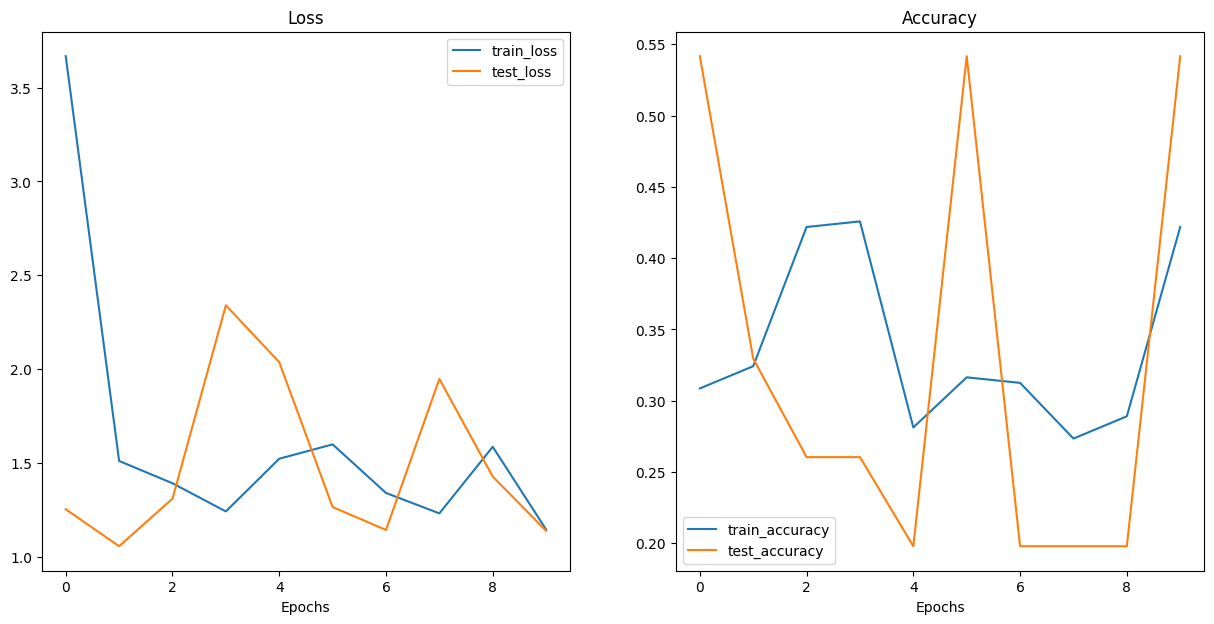

In [ ]:
from helper_functions import plot_loss_curves

plot_loss_curves(results)

## 10. Using a pre-trained ViT from `torchvision.models`

Generally in DL if you can use a pretrained model from a large dataset on your own problem, it's often a good place to start.

If you can find a pretrained model, and use transfer learning , give it a go, it often achieves great results with little data.

### 10.1 **Why use a pretrained model?**

* Sometimes data is limited
* Limited training resources
* Get better results fastes - sometimes


In [ ]:
# The following requires torchvision v0.12+ and torchvision 0.13+
import torch
import torchvision
print(torch.__version__)
print(torchvision.__version__)

2.6.0+cu118
0.21.0+cu118


In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"

device

'cuda'

### 10.2 Prepare a pretrained ViT for use with FoodVision Mini - turn it into a fature extractor

In [ ]:
# Get pretrained weights for ViT-base
pretrained_vit_weights = torchvision.models.ViT_B_16_Weights.DEFAULT  #Default is the best available in current present time

#Setup a ViT model instance with pretrained weights
pretrained_vit = torchvision.models.vit_b_16(weights=pretrained_vit_weights).to(device)

#pretrained_vit

# Freeze the base parameters
for parameter in pretrained_vit.parameters():
  parameter.requires_grad = False

# Update the classifier head - MLP Head
set_seeds()
pretrained_vit.heads = nn.Linear(in_features=768, out_features=len(class_names)).to(device)

Downloading: "https://download.pytorch.org/models/vit_b_16-c867db91.pth" to /root/.cache/torch/hub/checkpoints/vit_b_16-c867db91.pth
100%|██████████| 330M/330M [00:03<00:00, 113MB/s] 


In [ ]:
from torchinfo import summary

summary(model=pretrained_vit,
        input_size=(1,3,224,224),  # (batch_size, color_channels, weight, width)
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings = ["var_names"])



Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
VisionTransformer (VisionTransformer)                        [1, 3, 224, 224]     [1, 3]               768                  Partial
├─Conv2d (conv_proj)                                         [1, 3, 224, 224]     [1, 768, 14, 14]     (590,592)            False
├─Encoder (encoder)                                          [1, 197, 768]        [1, 197, 768]        151,296              False
│    └─Dropout (dropout)                                     [1, 197, 768]        [1, 197, 768]        --                   --
│    └─Sequential (layers)                                   [1, 197, 768]        [1, 197, 768]        --                   False
│    │    └─EncoderBlock (encoder_layer_0)                   [1, 197, 768]        [1, 197, 768]        (7,087,872)          False
│    │    └─EncoderBlock (encoder_layer_1)                   [1, 197, 768]        [1, 1

### 10.3 Preparing data for the pretrained ViT model

When using a pretrained model, you want to make sure your data is formatted in the same way that the model was trained on.

In [ ]:
# Get automatic transforms from pretrained ViT weights
vit_transforms = pretrained_vit_weights.transforms()
vit_transforms

ImageClassification(
    crop_size=[224]
    resize_size=[256]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BILINEAR
)

In [ ]:
train_dir, test_dir

(PosixPath('data/pizza_steak_sushi/train'),
 PosixPath('data/pizza_steak_sushi/test'))

In [ ]:
# Setup dataloaders
from going_modular.going_modular import data_setup
train_dataloader_pretrained, test_dataloader_pretrained, class_names = data_setup.create_dataloaders(train_dir=train_dir,
                                                                                                     test_dir=test_dir,
                                                                                                     transform=vit_transforms,
                                                                                                     batch_size=32)  # Could set a higher batch size because using a pretrained model

### 10.4 Traing feature extractor ViT model

In [ ]:
from going_modular.going_modular import engine

# Build optimizer and loss function
optimizer = torch.optim.Adam(params=pretrained_vit.parameters(),
                             lr=0.001)

loss_fn = torch.nn.CrossEntropyLoss()

# Train the classifier head of pretrained ViT
set_seeds()
pretrained_vit_results = engine.train(model=pretrained_vit,
                                      train_dataloader=train_dataloader_pretrained,
                                      test_dataloader=test_dataloader_pretrained,
                                      optimizer=optimizer,
                                      loss_fn=loss_fn,
                                      epochs=10,
                                      device=device)

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.7663 | train_acc: 0.7188 | test_loss: 0.5435 | test_acc: 0.8769
Epoch: 2 | train_loss: 0.3436 | train_acc: 0.9453 | test_loss: 0.3257 | test_acc: 0.8977
Epoch: 3 | train_loss: 0.2068 | train_acc: 0.9492 | test_loss: 0.2698 | test_acc: 0.9186
Epoch: 4 | train_loss: 0.1557 | train_acc: 0.9609 | test_loss: 0.2414 | test_acc: 0.9186
Epoch: 5 | train_loss: 0.1244 | train_acc: 0.9727 | test_loss: 0.2271 | test_acc: 0.8977
Epoch: 6 | train_loss: 0.1210 | train_acc: 0.9766 | test_loss: 0.2122 | test_acc: 0.9280
Epoch: 7 | train_loss: 0.0933 | train_acc: 0.9766 | test_loss: 0.2342 | test_acc: 0.8883
Epoch: 8 | train_loss: 0.0793 | train_acc: 0.9844 | test_loss: 0.2268 | test_acc: 0.9081
Epoch: 9 | train_loss: 0.1084 | train_acc: 0.9883 | test_loss: 0.2064 | test_acc: 0.9384
Epoch: 10 | train_loss: 0.0646 | train_acc: 0.9922 | test_loss: 0.1795 | test_acc: 0.9176


### 10.5 Plot the loss curves of our pretrained ViT feature extractor model

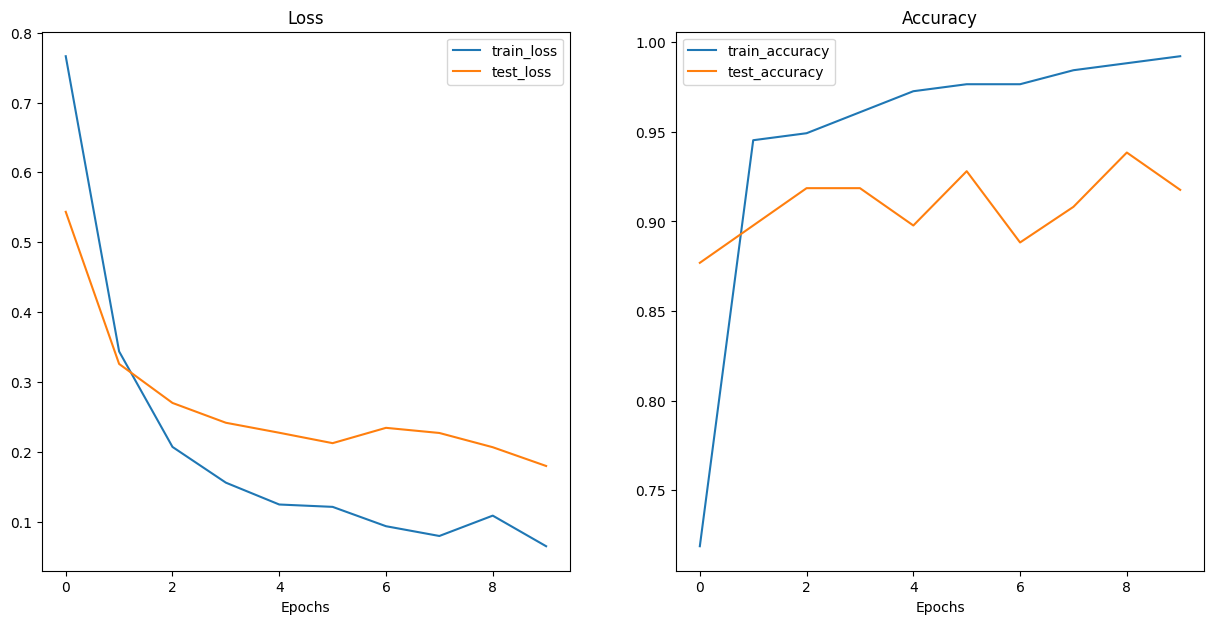

In [ ]:
from helper_functions import plot_loss_curves

plot_loss_curves(pretrained_vit_results)

### 10.6 Save our best performing ViT model

Now we have got a model that performs quite well, how about we save it to file and then check it's filesize.

We want ot check the filesize because if we wanted to deploy a model to say a website/mobile application, we may have limitations on the size of the model we can deploy.

E.g.: A smaller model may required due to compute restrictions

In [ ]:
# Save the model
from going_modular.going_modular import utils

utils.save_model(model=pretrained_vit,
                 target_dir="models",
                 model_name="08_pretrained_vit_feature_extractor_pizza_steak_sushi.pth")

[INFO] Saving model to: models/08_pretrained_vit_feature_extractor_pizza_steak_sushi.pth


In [ ]:
from pathlib import Path

#Get the model size in bytes then convert to megabytes
pretrained_vit_model_size = Path("models/08_pretrained_vit_feature_extractor_pizza_steak_sushi.pth").stat().st_size // (1024*1024)

print(f"Pretrained ViT feature extractor model size: {pretrained_vit_model_size} MB")

Pretrained ViT feature extractor model size: 327 MB


Our pretrained ViT gets some of the best results we have seen so far on our FoodVision Mini Problem, however, the model size is ~11x larger than our best performing model.

Peharps the larger model size might cause issues when we got deploy it (eg. hard to deploy such a large file/might not make predictions as fast as a smaller model).

## 11. Predicting on a custom image

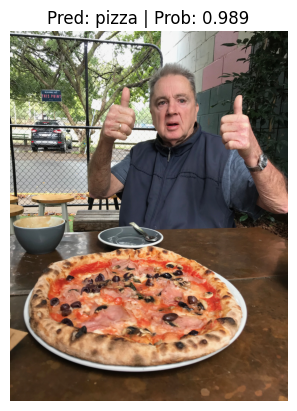

In [ ]:
import requests

# Import function to make predictions on images and plot them
from going_modular.going_modular.predictions import pred_and_plot_image

# Setup custom image path
custom_image_path = image_path / "04-pizza-dad.jpeg"

# Download the image if it doesn't already exist
if not custom_image_path.is_file():
    with open(custom_image_path, "wb") as f:
        # When downloading from GitHub, need to use the "raw" file link
        request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/images/04-pizza-dad.jpeg")
        print(f"Downloading {custom_image_path}...")
        f.write(request.content)
else:
    print(f"{custom_image_path} already exists, skipping download.")

# Predict on custom image
pred_and_plot_image(model=pretrained_vit,
                    image_path=custom_image_path,
                    class_names=class_names)